### Load Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
os.chdir('gdrive/My Drive/Colab Notebooks/HYBRID')

In [4]:
!pip install pynrrd

### Data loading functions

In [5]:
import numpy as np
import nrrd
msk, hdr = nrrd.read('./Chatterjee-vein-20200131134336.nrrd')

In [6]:
Mask = np.transpose(msk, axes=(1, 0, 2))
Mask.shape

(128, 128, 18)

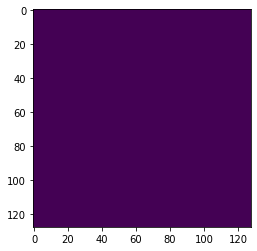

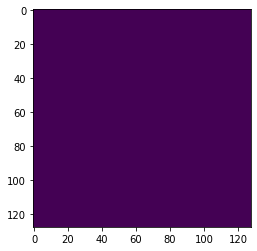

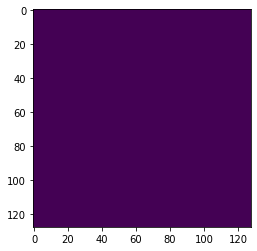

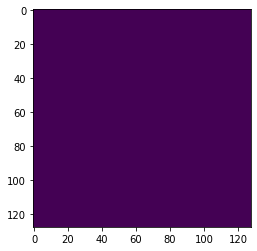

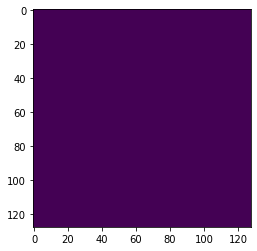

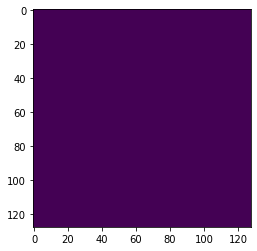

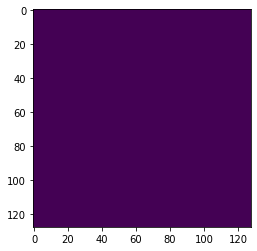

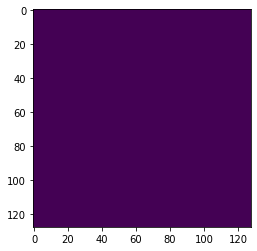

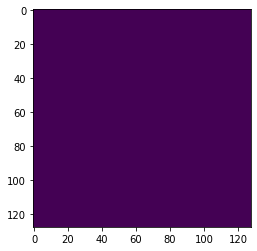

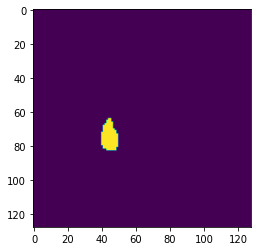

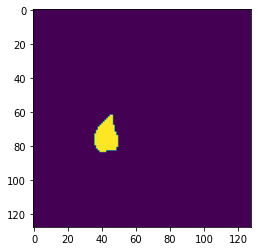

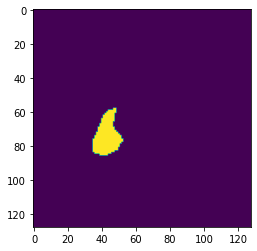

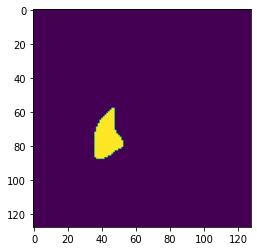

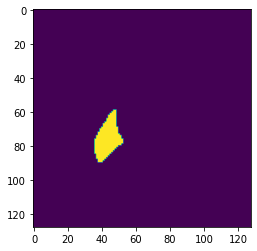

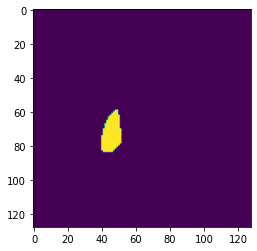

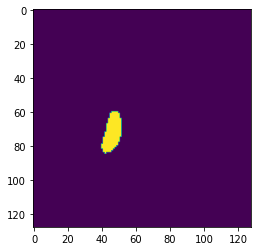

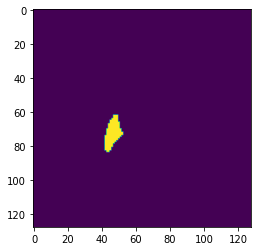

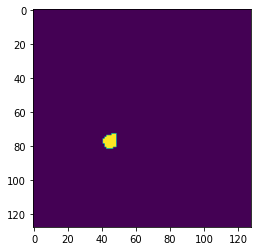

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

for idx in range(Mask.shape[2]):
    plt.imshow(Mask[:,:,idx])
    plt.show()

In [8]:
from scipy.io import loadmat
import os
import h5py
Assem_data = dict()
Label_data = dict()

def pixel_coord(img_slice, label_slice, slice_num):
    img_dict = dict()
    label_dict = dict()
    for s in range(slice_num):
        for i in range(img_slice.shape[0]):
            for j in range(img_slice.shape[1]):
                img_dict[(i,j,s)] = img_slice[i,j,s, :]
                if label_slice is not None:
                    label_dict[(i,j,s)] = label_slice[i,j,s]
    
    return img_dict, label_dict
    

for F in os.listdir():
    if F.endswith('.mat'):
        try:
            temp_mat = loadmat(F)
        except:
            temp_mat = h5py.File(F)
        #f = h5py.File(F)
        #with h5py.File(F, 'r') as f:
        Label_data[F] = None
        for k in temp_mat.keys():
            if 'hybrid_data' in k and 'crop' not in k:
                print(temp_mat[k].shape)
                if temp_mat[k].shape[0] == 4 and temp_mat[k].shape[1] == 4:
                    temp = np.moveaxis(temp_mat[k], 0, -1)
                    temp = np.moveaxis(temp, 0, -1)
                    temp = np.moveaxis(temp, 0, 2)
                    t = temp.reshape((temp.shape[0], temp.shape[1], temp.shape[2], 16))
                    #### divided by (0, 0) position
                    for i in range(t.shape[2]):
                        t[:,:,i,:] = t[:,:,i,:]/(t[:,:,i,0][:,:,np.newaxis]+1)
                    ####
                    Assem_data[F] = t
                else:
                    t = np.reshape(temp_mat[k], (temp_mat[k].shape[0], temp_mat[k].shape[1], temp_mat[k].shape[2], 16))
                    #### divided by (0, 0) position
                    for i in range(t.shape[2]):
                        t[:,:,i,:] = t[:,:,i,:]/(t[:,:,i,0][:,:,np.newaxis]+1)
                    ####
                    Assem_data[F] = t
            '''
            elif 'vein' in k:
                if temp_mat[k].shape[0] != 128:
                    temp = np.movelaxis(temp_mat[k], 0, -1)
                    Label_data[F] = temp
                else:
                    Label_data[F] = temp_mat[k]
            '''
            if 'pt108.mat' in F:
              Label_data[F] = Mask
        Assem_data[F], Label_data[F] = pixel_coord(Assem_data[F], Label_data[F], Assem_data[F].shape[2])
            
        #arrays[k] = np.array(v)

(128, 128, 18, 4, 4)
(128, 128, 18, 4, 4)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


(4, 4, 20, 128, 128)
(4, 4, 18, 128, 128)
(4, 4, 18, 128, 128)


### file examination

In [9]:
'''
for key in Label_data.keys():
  print(len(Label_data[key].keys()))
'''
for key in Assem_data.keys():
    print(len(Assem_data[key].keys()))
    #for idx, k in enumerate(Assem_data[key].keys()):
      #if idx % 128 == 0:
        #print(k, Assem_data[key][k].shape)


294912
294912
327680
294912
294912


### Decision tree model

In [21]:
T = list(range(0,18))
t = list (range(0,5))
list(set(T) -set(t))

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [32]:
### Assem_data, Label_data
### train, test split
from sklearn.model_selection import train_test_split

train_set_idx = []
test_set_idx = []
for key in Assem_data.keys():
    if 'R01_HM_MRI_pt108' in key:
        data_slices = [x for x in range(9, 18)]
        trainX_slice, testX_slice, trainY_slice, testY_slice = train_test_split(data_slices, data_slices, test_size = 0.3, random_state = 0) 
        #testX_slice = list(set(list(range(0,18))) - set(trainX_slice))
        #testY_slice = list(set(list(range(0,18))) - set(trainY_slice))
        for k in Assem_data[key].keys():
            if k[2] in trainX_slice:
                train_set_idx.append(k)
            else:
                test_set_idx.append(k)

print(trainX_slice, testX_slice, trainY_slice, testY_slice)

[13, 17, 15, 12, 9, 14] [16, 11, 10] [13, 17, 15, 12, 9, 14] [16, 11, 10]


In [25]:
train_x = [Assem_data['R01_HM_MRI_pt108.mat'][i] for i in train_set_idx]
train_y = [Label_data['R01_HM_MRI_pt108.mat'][i] for i in train_set_idx]

test_x = [Assem_data['R01_HM_MRI_pt108.mat'][i] for i in test_set_idx]
test_y = [Label_data['R01_HM_MRI_pt108.mat'][i] for i in test_set_idx]

In [29]:
print(len(train_x), len(train_y))
print(len(test_x), len(test_y))

98304 98304
196608 196608


### Decision Tree

In [30]:
from sklearn import tree
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
clf = tree.DecisionTreeClassifier(max_depth = 5)
clf = clf.fit(train_x, train_y)

In [31]:
test_score = clf.score(test_x, test_y)
#print(test_score)
test_pred = clf.predict(test_x)
print("Accuracy:", metrics.accuracy_score(test_y, test_pred))

0.9964599609375
Accuracy: 0.9964599609375


In [ ]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


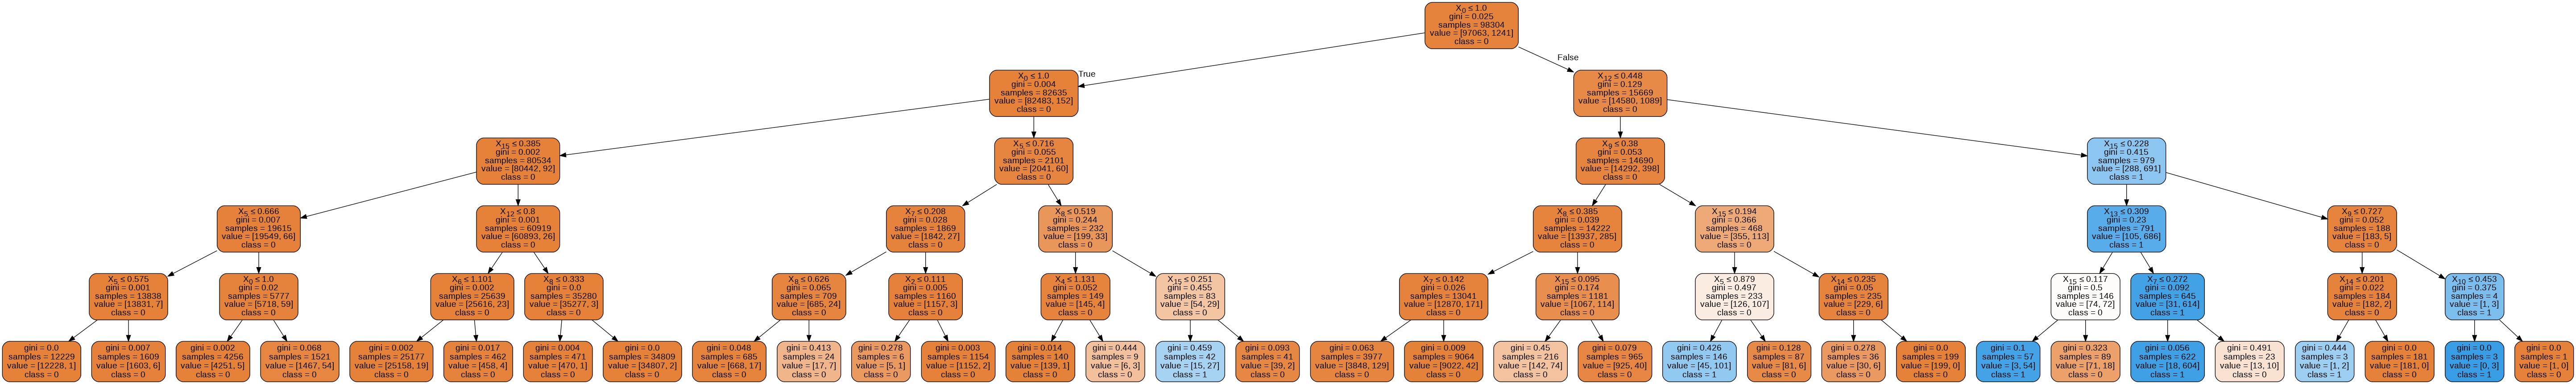

In [ ]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Hybrid_data_tree.png')
Image(graph.create_png())

####### https://www.datacamp.com/community/tutorials/decision-tree-classification-python
Optimizing Decision Tree Performance
criterion : optional (default=”gini”) or Choose attribute selection measure: This parameter allows us to use the different-different attribute selection measure. Supported criteria are “gini” for the Gini index and “entropy” for the information gain.

splitter : string, optional (default=”best”) or Split Strategy: This parameter allows us to choose the split strategy. Supported strategies are “best” to choose the best split and “random” to choose the best random split.

max_depth : int or None, optional (default=None) or Maximum Depth of a Tree: The maximum depth of the tree. If None, then nodes are expanded until all the leaves contain less than min_samples_split samples. The higher value of maximum depth causes overfitting, and a lower value causes underfitting (Source).

#### prediction and plot

In [ ]:
np_temp = np.zeros((128, 128, 18))
np_label = np.zeros
for idx in range(len(test_pred)):
    np_temp[test_set_idx[idx][0], test_set_idx[idx][1], test_set_idx[idx][2]] = test_pred[idx] 



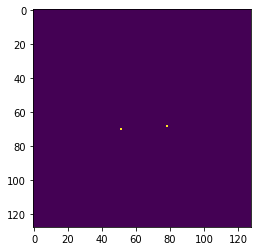

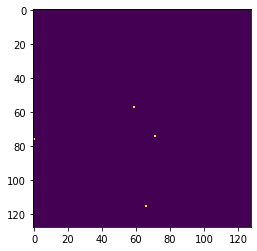

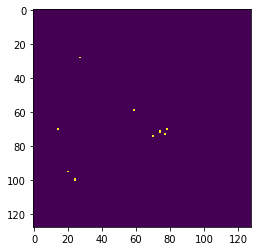

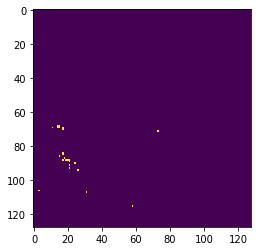

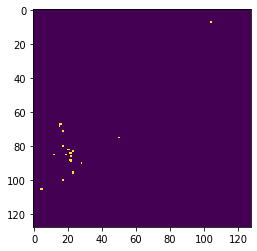

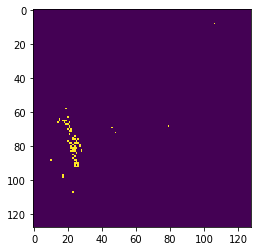

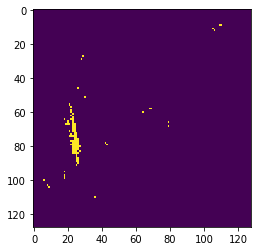

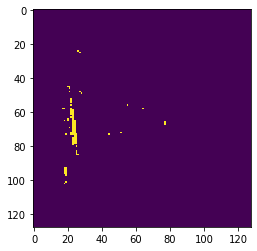

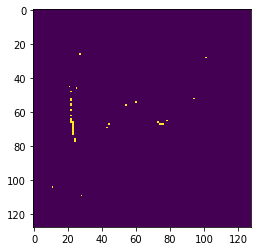

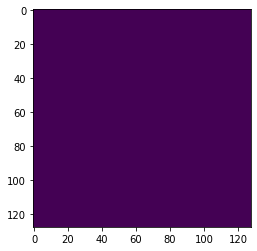

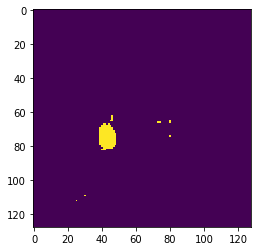

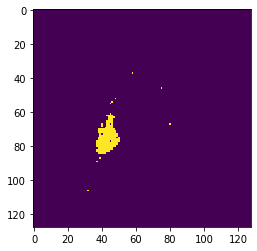

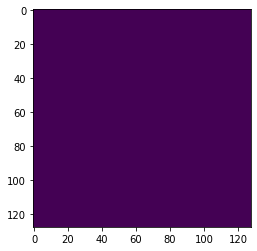

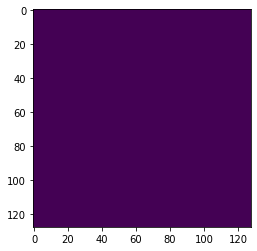

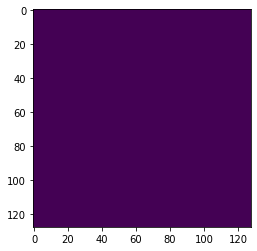

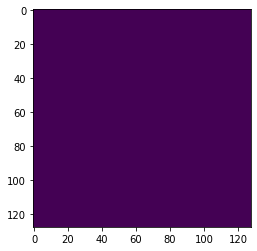

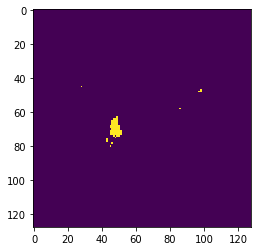

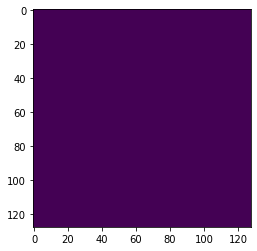

In [ ]:
%matplotlib inline  
import matplotlib.pyplot as plt

for i in range(18):
  plt.imshow(np_temp[:,:,i])
  plt.show()

### Random Forest and Tree Bagging

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RF_clf = RandomForestClassifier(n_estimators=100, max_depth=6, max_features = 'sqrt',verbose = 1, bootstrap =True)
RF_clf.fit(train_x, train_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=1, warm_start=False)

In [ ]:
test_score = RF_clf.score(test_x, test_y)
test_score
test_pred = RF_clf.predict(test_x)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished


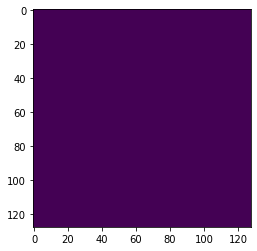

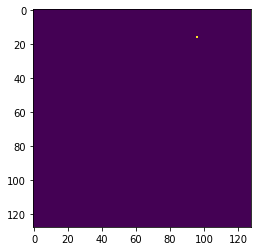

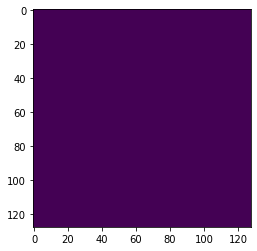

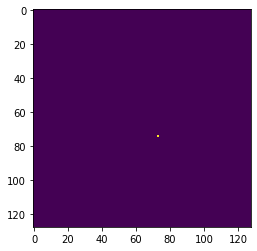

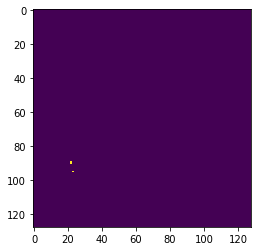

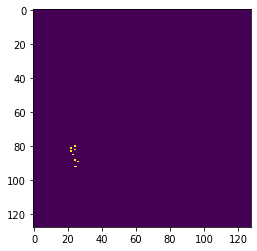

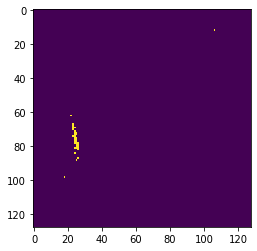

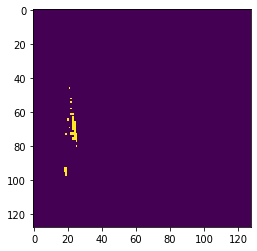

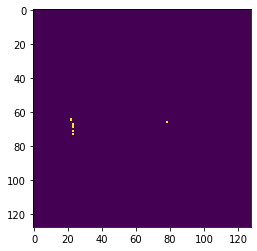

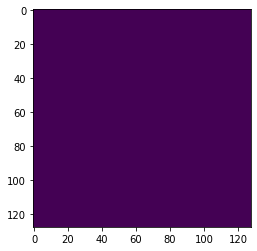

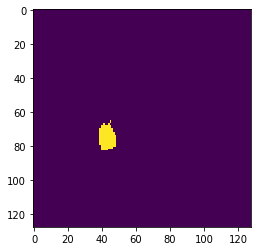

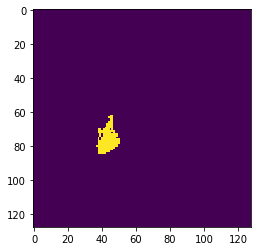

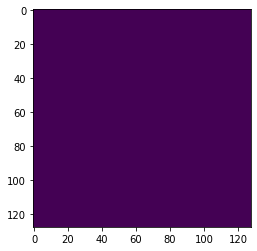

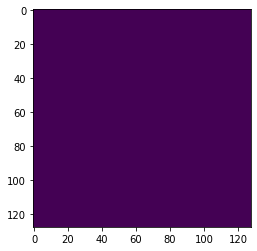

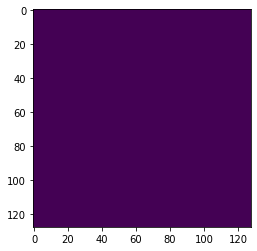

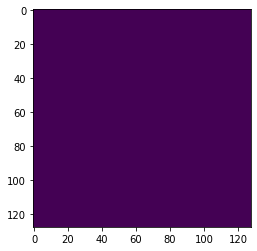

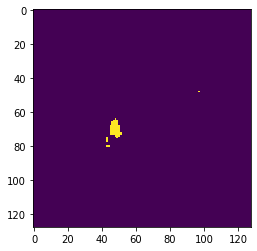

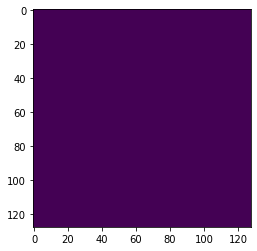

In [ ]:
np_temp = np.zeros((128, 128, 18))

for idx in range(len(test_pred)):
    np_temp[test_set_idx[idx][0], test_set_idx[idx][1], test_set_idx[idx][2]] = test_pred[idx] 


for i in range(18):
  plt.imshow(np_temp[:,:,i])
  plt.show()


In [ ]:
dot_data = StringIO()
export_graphviz(RF_clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Hybrid_data_RFree.png')
Image(graph.create_png())

AttributeError: ignored

### Gradient Descent Boosting
https://machinelearningmastery.com/visualize-gradient-boosting-decision-trees-xgboost-python/
The [XGBoost Python API](http://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.plotting) provides a function for plotting decision trees within a trained XGBoost model.<br>Generally, importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.<br>
This importance is calculated explicitly for each attribute in the dataset, allowing attributes to be ranked and compared to each other.

Importance is calculated for a single decision tree by the amount that each attribute split point improves the performance measure, weighted by the number of observations the node is responsible for. The performance measure may be the purity (Gini index) used to select the split points or another more specific error function.

The feature importances are then averaged across all of the the decision trees within the model.



In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

dtest = xgb.DMatrix(test_x, test_y)
dtrain = xgb.DMatrix(train_x, train_y)

In [ ]:
param = {'max_depth': 6, 
         'learning_rate': 0.3, 
         'verbosity': 1, 
         'objective': 'binary:logistic', 
         'num_class': 2, 
         'eval_metric': 'merror'}

evallist = [(dtrain, 'train')]

In [ ]:
model = xgb.XGBClassifier(max_dpeth = 8, random_state = 1, learning_rate = 0.1, susample = 0.9)
model.fit(np.array(train_x), np.array(train_y))
model.score(np.array(test_x), np.array(test_y))


0.9976043701171875

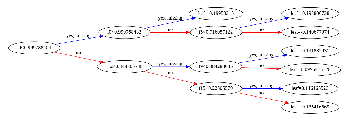

In [ ]:
# plot single tree
from xgboost import plot_tree
import matplotlib.pyplot as plt

plot_tree(model, rankdir='LR')#, num_trees = 4)
plt.show()


#### Manually Plot Feature Importance

A trained XGBoost model automatically calculates feature importance on your predictive modeling problem.

These importance scores are available in the feature_importances_ member variable of the trained model.

In [ ]:
print(model.feature_importances_)

[0.1162884  0.02795839 0.02821655 0.05978896 0.01390372 0.01889773
 0.0132183  0.07310925 0.15160537 0.11592203 0.00685513 0.0513458
 0.1614394  0.02987677 0.02003859 0.11153562]


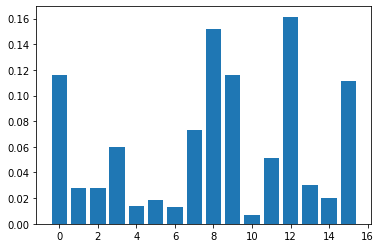

In [ ]:
#We can plot these scores on a bar chart directly to get a visual indication of the relative importance of each feature in the dataset.
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

#### Using the Built-in XGBoost feature importance plot

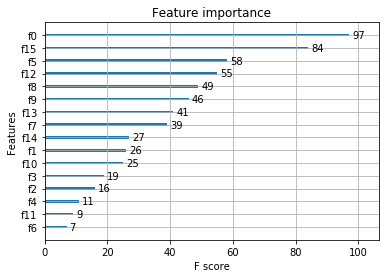

In [ ]:
# plot feature importance
from xgboost import plot_importance
plot_importance(model)
plt.show()

In [ ]:
test_pred = model.predict(np.array(test_x))
accuracy = accuracy_score(test_y, test_pred)
print(accuracy)

0.9976043701171875


In [ ]:
# Fit model using each importance as a threshold
from numpy import sort
from sklearn.feature_selection import SelectFromModel

thresholds = sort(model.feature_importances_)
#print(thresholds)

for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(model, threshold=thresh, prefit=True)
	select_X_train = selection.transform(train_x)
	# train model
	selection_model = xgb.XGBClassifier()
	selection_model.fit(select_X_train, train_y)
	# eval model
	select_X_test = selection.transform(test_x)
	y_pred = selection_model.predict(select_X_test)
	predictions = [round(value) for value in y_pred]
	accuracy = accuracy_score(test_y, predictions)
	print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
  

Thresh=0.007, n=16, Accuracy: 99.76%
Thresh=0.013, n=15, Accuracy: 99.76%
Thresh=0.014, n=14, Accuracy: 99.76%
Thresh=0.019, n=13, Accuracy: 99.76%
Thresh=0.020, n=12, Accuracy: 99.76%
Thresh=0.028, n=11, Accuracy: 99.77%
Thresh=0.028, n=10, Accuracy: 99.75%
Thresh=0.030, n=9, Accuracy: 99.75%
Thresh=0.051, n=8, Accuracy: 99.75%
Thresh=0.060, n=7, Accuracy: 99.74%
Thresh=0.073, n=6, Accuracy: 99.74%
Thresh=0.112, n=5, Accuracy: 99.72%
Thresh=0.116, n=4, Accuracy: 99.49%
Thresh=0.116, n=3, Accuracy: 99.54%
Thresh=0.152, n=2, Accuracy: 99.66%
Thresh=0.161, n=1, Accuracy: 99.66%


https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

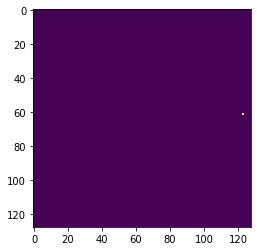

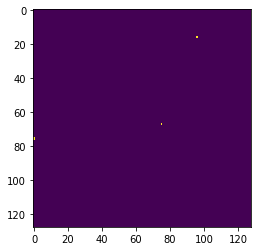

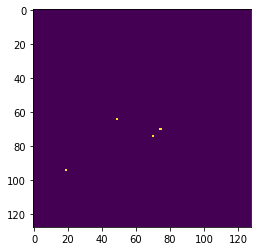

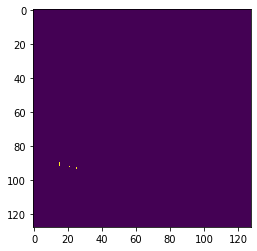

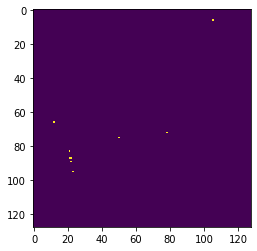

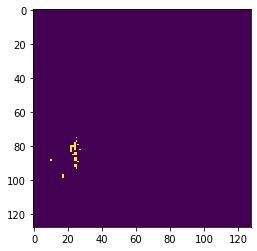

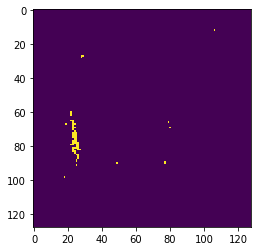

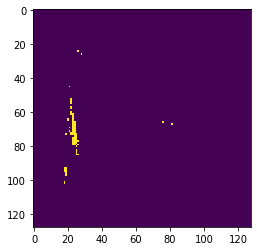

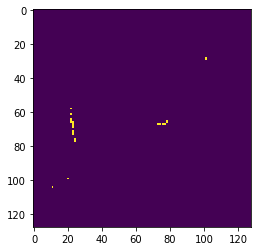

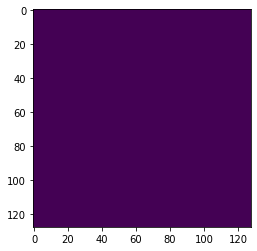

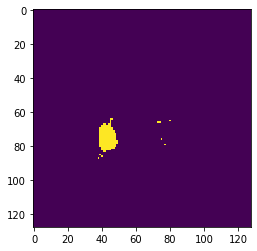

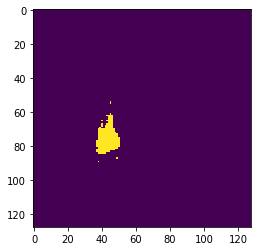

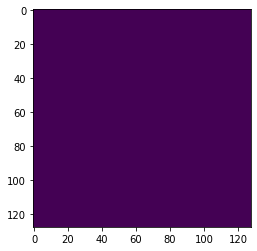

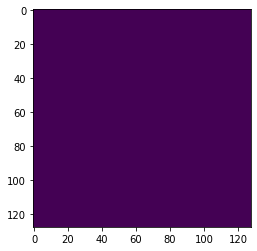

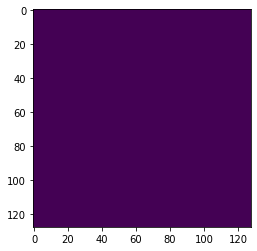

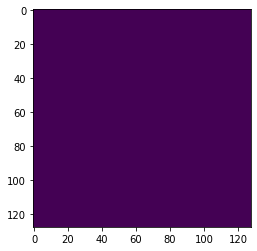

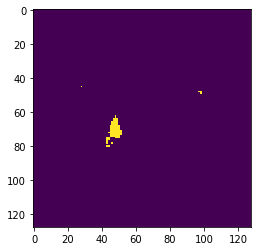

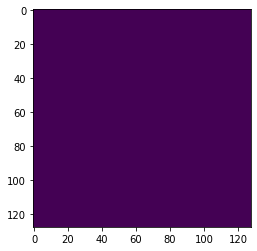

In [ ]:
np_temp = np.zeros((128, 128, 18))

for idx in range(len(test_pred)):
    np_temp[test_set_idx[idx][0], test_set_idx[idx][1], test_set_idx[idx][2]] = test_pred[idx] 


for i in range(18):
  plt.imshow(np_temp[:,:,i])
  plt.show()